### Generating text with char-rnn

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
%matplotlib inline

In [6]:
# data I/O
data1 = open('alice in wonderland.txt', 'r').read().lower() # should be simple plain text file
removed_chars = set("""1234567890;:_`()*[]'""")
chars = list(set(data)-removed_chars)

data = ''.join([c for c in data1 if c in chars])
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 144230 characters, 34 unique.


In [8]:
print(data[:200])

alices adventures in wonderland



                          lewis carroll

               the millennium fulcrum edition .
                     c duncan research



chapter i     down the rabbit-hole


### hyperparameters

In [7]:
hidden_size = 128 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

### model parameters

In [9]:
np.random.seed(seed=34)
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

### Exercise 1.1: forward pass

$$h_{t} = tanh(W_{hh}h_{t-1} + W_{xh}x + b_{h})$$
$$y = W_{hy}h_{t} + b_{y}$$
$$p = softmax(p) = {e^{y} \over \sum e^{y}}$$

According to the above equations, implement a forward pass of the RNN model

In [32]:
def forward_pass(wxh, whh, why, bh, by, h, x):   # noviy state i veroyatnost simvolov kotoriy stoit sleduyushim
    # your code goes here
    
    # hidden state
    hid_st = np.tanh( np.dot(whh,h) + np.dot(wxh,x) + bh)  # np.matmul(whh,h ) ...
#     print(hid_st.shape)
    # unnormalized log probabilities for next chars
    y = np.matmul(why, hid_st) + by
#     print(y.shape)
    # probabilities for next chars
    p = np.exp(y) /np.sum(np.exp(y))
#     print(p.shape, '\nShapes\n')

    return hid_st, y, p

In [25]:
_wxh = np.ones((hidden_size, vocab_size))*0.01
_whh = np.ones((hidden_size, hidden_size))*0.02
_why = np.ones((vocab_size, hidden_size))*0.03
_bh = np.zeros((hidden_size, 1))
_by = np.zeros((vocab_size, 1))
_h = np.ones(hidden_size)*0.04
_tx = np.zeros((vocab_size,1))
_tx[[char_to_ix[ch] for ch in data[:seq_length]]] = 1

_r = forward_pass(_wxh, _whh, _why, _bh, _by, _h, _tx)

_t = np.load('test_case_1.npy')

assert np.sum([np.linalg.norm(_r[i]-_t[i]) for i in range(3)]) < 1e-6
print('done')

(128, 128)
(34, 128)
(34, 128) 
Shapes

done


### Exercise 1.2: sampling

Implement a function that samples new characters from the model

In [26]:
def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h, y, p = forward_pass(Wxh, Whh, Why, bh, by, h, x)
        # p is the probability distribution over all possible characters
        # sample an ID of a new character from the list of possible character IDs, 
        # according to probability distribution p 
        
        # your code goes here
        # then encode your new character as a one-hot vector and add to the list of outputs
        ix = np.random.choice(range(vocab_size), p = p.ravel() ) # ravel-y shape-n e poxum
        x = np.zeros([vocab_size, 1])
        x[ix] = 1
        ixes.append(ix)
    return ixes

In [27]:
_r = sample(_bh, [char_to_ix[ch] for ch in data[:seq_length]], 10)
assert isinstance(_r, list)
assert len(_r) == 10
assert all([isinstance(i, np.int64) for i in _r]) and all([i<vocab_size for i in _r])
print('done')

(128, 1)
(34, 1)
(34, 1) 
Shapes

(128, 1)
(34, 1)
(34, 1) 
Shapes

(128, 1)
(34, 1)
(34, 1) 
Shapes

(128, 1)
(34, 1)
(34, 1) 
Shapes

(128, 1)
(34, 1)
(34, 1) 
Shapes

(128, 1)
(34, 1)
(34, 1) 
Shapes

(128, 1)
(34, 1)
(34, 1) 
Shapes

(128, 1)
(34, 1)
(34, 1) 
Shapes

(128, 1)
(34, 1)
(34, 1) 
Shapes

(128, 1)
(34, 1)
(34, 1) 
Shapes

done


### Exercise 1.3: training

The loss function and the backward pass has been implemented for you. Train the model and observe the results.

In [28]:
def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t], ys[t], ps[t] = forward_pass(Wxh, Whh, Why, bh, by, hs[t-1], xs[t])
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
        
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 
        # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [30]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

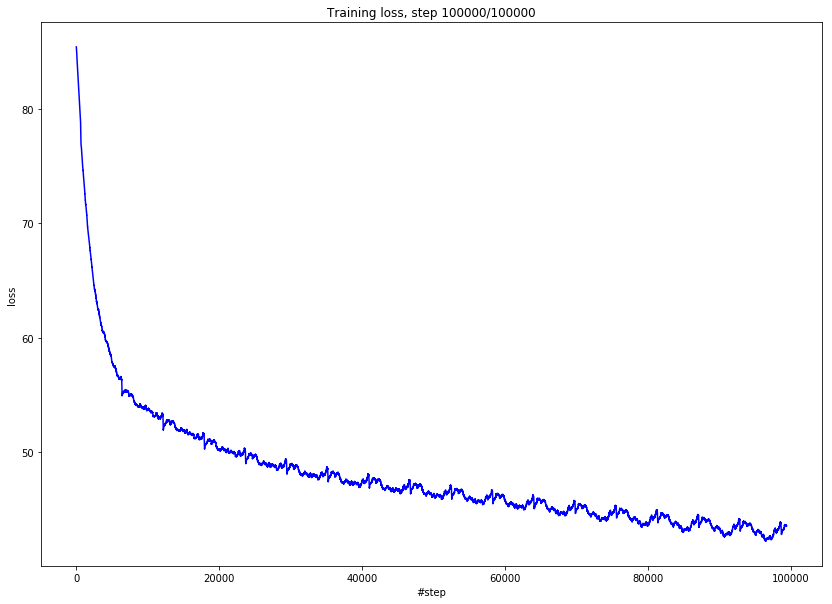

----
 e walling hire-- shent and dyar.

  youd a dupid onen hordering the book, the harty
the begans crow her hersto, and not vere
the poocking abous thabpelfafsy?  pouse
of bely, anviliutidy turavest thes  
----


In [33]:
lh = []
report_every = 1000
num_steps = 100000

while True:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

      # sample from the model now and then
    if n % report_every == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        #print('----\n {} \n----'.format(txt))

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    lh.append(smooth_loss)
    
    if n % report_every == 0:
        #print('iter {}, loss: {}'.format(n, smooth_loss)) # print progress
        display.clear_output(wait=True)
        plt.figure(figsize=(14, 10))
        plt.title("Training loss, step {}/{}".format(n, num_steps))
        plt.xlabel("#step")
        plt.ylabel("loss")
        plt.plot(lh, 'b')
        plt.show()
        print('----\n {} \n----'.format(txt))
        
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                  [dWxh, dWhh, dWhy, dbh, dby],
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter
    
    if n > num_steps:
        break